In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot  as plt
import os
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/launching_into_ml/solutions/TrainingWithXGBoostInCMLE.ipynb

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/launching_into_ml/solutions/decision_trees_and_random_Forests_in_Python.ipynb

#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/predictive_maintainance/predictive_maintenance_usecase.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/inventory-prediction/inventory_prediction.ipynb

# best
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/SDK_Custom_Container_Prediction.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/datasets/get_started_bq_datasets.ipynb

#https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/chicago_taxi_fare_prediction/chicago_taxi_fare_prediction.ipynb

#http://localhost:8888/lab/workspaces/auto-O/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_feature_importances_with_treeclassifier.ipynb
#http://localhost:8888/lab/workspaces/auto-C/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_classification_iris2.ipynb

#https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction

#chrome://bookmarks/?id=953

# upload downlload 
#https://medium.com/@jchavezar/ml-from-local-to-production-vertex-ai-d3b09998008c

#https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/main/notebooks/official/prediction
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/custom_batch_prediction_feature_filter.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/main/notebooks/official/model_registry
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/ads_targetting/training-multi-class-classification-model-for-ads-targeting-usecase.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/SDK_Custom_Container_Prediction.ipynb
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/machine_learning_in_the_enterprise/solutions/sdk_custom_xgboost.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/sdk/SDK_Custom_Training_Python_Package_Managed_Text_Dataset_Tensorflow_Serving_Container.ipynb

In [12]:
print(xgb.__version__)
print(np.__version__)
print(pd.__version__)

1.6.2
1.22.4
1.5.0


In [13]:
# dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']
dateTimeCols=['open_datetime','close_datetime']

cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type','sla']

# numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']
numericFeatures=['count_detail','open_to_close_hour']

colLabel='severity_label'


calLabelRefInfo=[colLabel,'severity_name']

colFeatures=cateFeatures+numericFeatures

cols=[colLabel]+colFeatures

print(cols)




to_date='2023-12-31'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla', 'count_detail', 'open_to_close_hour']


# Load and Prepare Data

In [14]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
print(df_incident.info())


Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   severity_label           2068 non-null   int64         
 1   severity_name            2068 non-null   object        
 2   sla                      2068 non-null   object        
 3   id                       2068 non-null   int64         
 4   incident_no              2068 non-null   object        
 5   product_type             2068 non-null   object        
 6   brand                    2068 non-null   object        
 7   mode                     2068 non-null   object        
 8   customer_warranty_start  2068 non-null   object        
 9   customer_warranty_end    2068 non-null   object        
 10  incident_type            2068 non-null   object        
 11  status                   2068 non-null

In [15]:
df_incident=df_incident.query("open_datetime<=@to_date")
dfLabelRefInfo=df_incident[calLabelRefInfo]
df_incident=df_incident[cols]

In [16]:
print(df_incident.info())
df_incident.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   severity_label      2068 non-null   int64  
 1   product_type        2068 non-null   object 
 2   brand               2068 non-null   object 
 3   incident_type       2068 non-null   object 
 4   service_type        2068 non-null   object 
 5   is_failure_type     2068 non-null   bool   
 6   sla                 2068 non-null   object 
 7   count_detail        2068 non-null   int64  
 8   open_to_close_hour  2068 non-null   float64
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 147.4+ KB
None


,severity_label,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour
2063,2,Storage,NetApp,General Incident,Request,False,24x7 4Hrs Response Time,2,837.850000
2064,2,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667
2065,2,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667
2066,2,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333
2067,2,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000


In [17]:
dfLabelRefInfo['severity']=dfLabelRefInfo.apply(lambda x:  f"{x.severity_label}-{x.severity_name}" ,axis=1)
print(dfLabelRefInfo.info())
dfLabelRefInfo.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   severity_label  2068 non-null   int64 
 1   severity_name   2068 non-null   object
 2   severity        2068 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.6+ KB
None


,severity_label,severity_name,severity
2063,2,Major,2-Major
2064,2,Major,2-Major
2065,2,Major,2-Major
2066,2,Major,2-Major
2067,2,Major,2-Major


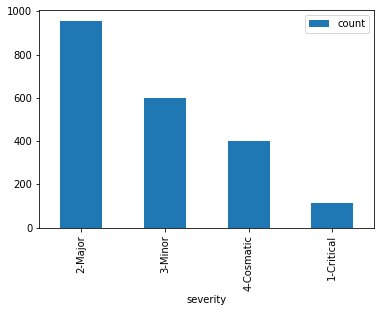

,count
severity,
2-Major,956
3-Minor,599
4-Cosmatic,400
1-Critical,113


In [18]:
dfLabelSummary=dfLabelRefInfo.groupby(['severity']).size().to_frame('count').sort_values(by='count',ascending=False)

dfLabelSummary.plot(kind='bar')
plt.show()
dfLabelSummary

product_type


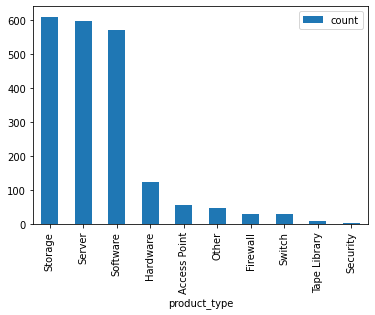

brand


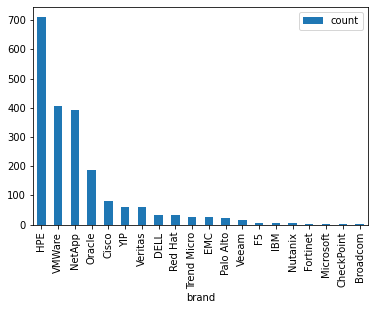

incident_type


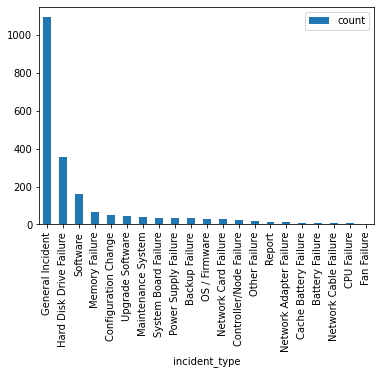

service_type


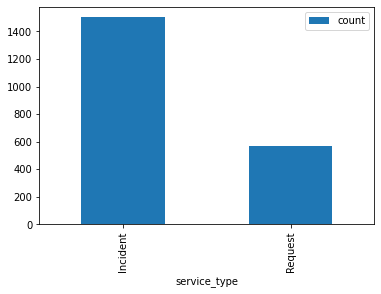

is_failure_type


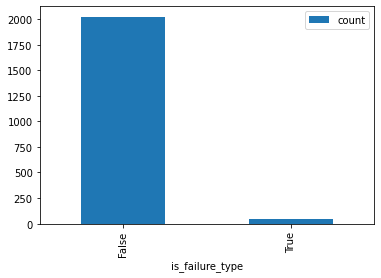

sla


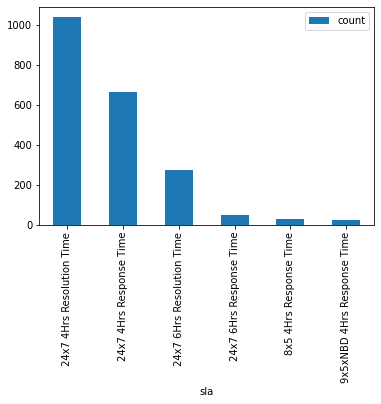

In [19]:
for col in cateFeatures:
    print(col)
    dfGroupCate=df_incident.groupby([col]).size().to_frame('count').sort_values(by='count',ascending=False)
    dfGroupCate.plot(kind='bar')
    plt.show()


D:\ProgramData\Anaconda3\envs\myquant_exp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


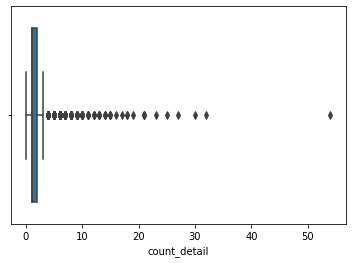

D:\ProgramData\Anaconda3\envs\myquant_exp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


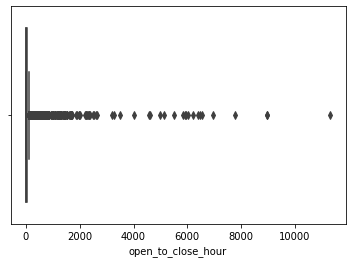

In [20]:
# df_incident[numericFeatures].plot(kind='hist', subplots=True, layout=(len(numericFeatures),1), sharex=False)
for col in numericFeatures:
    sns.boxplot(df_incident[col])
    plt.show()

# Process features and target class

In [21]:
# cateFeatures_cateLabel=cateFeatures.copy()+[colLabel]
print(f"{cateFeatures} and {colLabel}")
X = df_incident.loc[:,colFeatures]
X[cateFeatures]=X[cateFeatures].astype("category") 

print(X.info())
X.sample(10)


['product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla'] and severity_label
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   product_type        2068 non-null   category
 1   brand               2068 non-null   category
 2   incident_type       2068 non-null   category
 3   service_type        2068 non-null   category
 4   is_failure_type     2068 non-null   category
 5   sla                 2068 non-null   category
 6   count_detail        2068 non-null   int64   
 7   open_to_close_hour  2068 non-null   float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 62.8 KB
None


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour
569,Software,VMWare,General Incident,Request,False,24x7 4Hrs Response Time,1,8.566667
574,Server,HPE,System Board Failure,Incident,False,24x7 4Hrs Resolution Time,1,5.400000
1857,Other,HPE,General Incident,Incident,False,24x7 4Hrs Resolution Time,1,0.716667
1865,Server,HPE,General Incident,Request,False,24x7 4Hrs Resolution Time,1,4.000000
1220,Server,HPE,General Incident,Incident,False,9x5xNBD 4Hrs Response Time,3,80.550000
1221,Other,Veritas,Backup Failure,Incident,False,24x7 4Hrs Response Time,2,21.616667
2007,Storage,NetApp,Software,Request,False,24x7 4Hrs Response Time,2,5142.250000
1515,Server,HPE,Hard Disk Drive Failure,Incident,False,24x7 4Hrs Resolution Time,1,10.000000
44,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Resolution Time,3,1.550000
1261,Server,HPE,Maintenance System,Request,False,24x7 4Hrs Resolution Time,1,8.000000


In [22]:
y=df_incident.loc[:,colLabel]
print(y.info())
y.sample(10)
# y=y.astype("category")

<class 'pandas.core.series.Series'>
Int64Index: 2068 entries, 0 to 2067
Series name: severity_label
Non-Null Count  Dtype
--------------  -----
2068 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB
None


1017    3
2014    3
218     2
1517    1
1483    4
1820    4
1373    4
1258    2
1738    3
216     2
Name: severity_label, dtype: int64

In [23]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# print(label_encoder.classes_)

# print(y[-5:])

# Model Parameter Setting

In [24]:
maxDept=10
lerningRate=0.1
nEstimators=100

# Final Model

In [25]:
print("Use DMatrix & Train Object") 
xg_param= {'max_depth': maxDept, 'learning_rate': lerningRate}
dAllTrain = xgb.DMatrix(data= X, label=y,enable_categorical=True)
model_xg=xgb.train(xg_param,dAllTrain,num_boost_round=nEstimators)

Use DMatrix & Train Object


In [26]:
artifact_filename = 'model.bst'
local_path = artifact_filename

model_xg.save_model(local_path)

# file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'
# joblib.dump(scalerFinalTrain,file_scaler)

In [27]:
# from google.cloud import storage

# BUCKET_NAME='gs://smart-ai-model-pongthorn'
# MODEL_DIR = BUCKET_NAME + "/model"
# print(MODEL_DIR)


# storage_path = os.path.join(MODEL_DIR, artifact_filename)
# blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
# blob.upload_from_filename(local_path)

# storage_client = storage.Client()
# blob = storage.blob.Blob.from_string(MODEL_DIR, client=storage.Client())
# blob.upload_from_filename(local_path)

In [28]:
# def upload_blob(bucket_name, source_file_name, destination_blob_name):
#     """Uploads a file to the bucket."""

#     storage_client = storage.Client()
#     bucket = storage_client.bucket(bucket_name)
#     blob = bucket.blob(destination_blob_name)

#     blob.upload_from_filename(source_file_name)

#     destination_file_name = os.path.join("gs://", bucket_name, destination_blob_name)

#     return destination_file_name

# Train Data 

# Split Train and Test Data

In [29]:
seed = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

print("-----------------------------------------------------------------------------------------------------")
print(y_train[:5])
X_train[:5]



(1757, 8) (311, 8)
(1757,) (311,)
-----------------------------------------------------------------------------------------------------
396     2
113     2
1853    3
1269    4
1656    1
Name: severity_label, dtype: int64


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_13112\3656860413.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(y_train[:5])


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour
396,Storage,HPE,Hard Disk Drive Failure,Incident,False,24x7 6Hrs Resolution Time,1,5.500000
113,Software,VMWare,Software,Incident,False,24x7 4Hrs Response Time,2,5.500000
1853,Storage,Oracle,Hard Disk Drive Failure,Incident,False,24x7 4Hrs Resolution Time,1,7.500000
1269,Server,HPE,Maintenance System,Request,False,24x7 4Hrs Resolution Time,1,10.183333
1656,Storage,HPE,General Incident,Incident,False,24x7 4Hrs Resolution Time,0,1.566667


# XGBoost 

In [30]:
print("Use DMatrix & Train Object") 
xg_param= {'max_depth': maxDept, 'learning_rate': lerningRate}
dtrain = xgb.DMatrix(data= X_train, label=y_train,enable_categorical=True)
model_xg=xgb.train(xg_param,dtrain,num_boost_round=nEstimators)

dtest = xgb.DMatrix(data=X_test,label=y_test,enable_categorical=True)
y_pred_xg = model_xg.predict(dtest)


predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))


Use DMatrix & Train Object
XGBoost Accuracy: 78.14%


# Feature Important

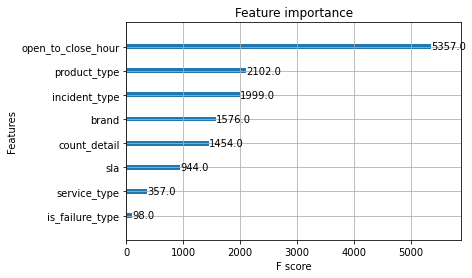

In [31]:
xgb.plot_importance(model_xg)
plt.show()